<a href="https://colab.research.google.com/github/kylelee417/Data-Science_Portfolio/blob/master/VAE%20V02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Installing chromedriver and selenium library for downloading more than 100 images

In [2]:
#source:https://darektidwell.com/using-selenium-with-google-colaboratory/
# Install cromium, its driver, and selenium
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

# Set options to be headless
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.get("https://www.webite-url.com")

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,622 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 256 kB in 2s (138 kB/s)
Reading package lists... Done
Reading package lists... Done
B

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: use options instead of chrome_options
  


In [3]:
!pip install google_images_download # - if necessary

In [0]:
from google_images_download import google_images_download
import os

In [0]:
#define and change the downlaoding path to current path
data_path = '/content/drive/My Drive/downloads'
data_path
os.chdir(data_path)

In [0]:
#creating object
response = google_images_download.googleimagesdownload()

search_queries = ['japanese men hair front']

In [0]:
def downloadimages(query):
    arguments = dict(keywords=query,
                    limit=1000,
                    format='jpg',
                    size = 'medium',
                    chromedriver= '/usr/lib/chromium-browser/chromedriver',
                    aspect_ratio='square',
                    silent_mode=True)
    try: 
        response.download(arguments)     
    except FileNotFoundError:  
        arguments = dict(keywords=query,
                    limit=20,
                    format='jpg',
                    size = 'medium',     
                    aspect_ratio='square',
                    print_urls=False)                       
        try:  
            response.download(arguments)  
        except: 
            pass

In [0]:
# Driver Code 

download_msg = []
for query in search_queries: 
    downloadimages(query)
    msg = 'Downloaded {} {} images!'.format(len(os.listdir(os.path.join(data_path,query))),query)
    download_msg.append(msg)
for msg in download_msg:
    print(msg)

###Load required library

In [8]:
#dependencies (numpy, matplotlib, and keras)
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob #retriving an array of files in directories
from scipy.stats import norm
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Lambda, Reshape, Dropout
from keras.models import Model
from keras import backend as K





Using TensorFlow backend.


In [0]:
men_hair = "/content/drive/My Drive/downloads/"

img_all_train = glob(men_hair+"/man hairstyle top view/train/*.jpg")

img_all_test = glob(men_hair+"/man hairstyle top view/test/*.jpg")



In [10]:
#source:https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution
# Preparing train, test data

train_data = []
test_data = []

#Train
for img in img_all_train:
    img = cv2.imread(str(img),0)
    img = cv2.resize(img, (96,96))   
    img = img.astype(np.float32)/255.
    img = np.expand_dims(img,-1)
    train_data.append(img)
    
#Test                      
for img in img_all_test:
    img = cv2.imread(str(img),0)
    img = cv2.resize(img, (96,96))
    img = img.astype(np.float32)/255.
    img = np.expand_dims(img,-1)
    test_data.append(img)
    

train_data = np.array(train_data)
test_data = np.array(test_data)

print("Total number of train examples: ", train_data.shape)
print("Total number of test examples:", test_data.shape)

Total number of train examples:  (455, 96, 96, 1)
Total number of test examples: (86, 96, 96, 1)


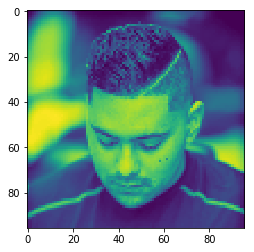

In [11]:
# First sample in the train set
plt.imshow(train_data[0].reshape(96,96))

### Normal Autoencoder

In [12]:
#input shape
input_img = Input(shape=(96,96,1))  # adapt this if using `channels_first` image data format

#Encoder part
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.20)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.20)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#Decoder part
x = Conv2DTranspose(32, (2,2),padding='same', activation='relu',strides=(2, 2))(encoded)
x = Conv2DTranspose(64, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(64, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(128,(2,2),padding='same', activation='relu',strides=(2, 2))(x)
decoded = Conv2D(1,(3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

W0811 17:14:04.466732 140071018502016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 17:14:04.488583 140071018502016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 17:14:04.493430 140071018502016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 17:14:04.513375 140071018502016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0811 17:14:04.532558 140071018502016 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
__________

In [13]:
autoencoder.fit(train_data, train_data,
                epochs=300,
                steps_per_epoch=int(len(train_data)/64),
                validation_steps=int(len(test_data)/64),
                shuffle=False,
                validation_data=(test_data, test_data), verbose=1)

Train on 455 samples, validate on 86 samples
Epoch 1/300
7/7 [==============================] - 20s 3s/step - loss: 0.6929 - val_loss: 0.6926
Epoch 2/300
7/7 [==============================] - 11s 2s/step - loss: 0.6925 - val_loss: 0.6923
Epoch 3/300
7/7 [==============================] - 11s 2s/step - loss: 0.6924 - val_loss: 0.6923
Epoch 4/300
7/7 [==============================] - 11s 2s/step - loss: 0.6924 - val_loss: 0.6922
Epoch 5/300
7/7 [==============================] - 11s 2s/step - loss: 0.6923 - val_loss: 0.6922
Epoch 6/300
7/7 [==============================] - 11s 2s/step - loss: 0.6923 - val_loss: 0.6922
Epoch 7/300
7/7 [==============================] - 11s 2s/step - loss: 0.6923 - val_loss: 0.6922
Epoch 8/300
7/7 [==============================] - 11s 2s/step - loss: 0.6923 - val_loss: 0.6922
Epoch 9/300
7/7 [==============================] - 11s 2s/step - loss: 0.6922 - val_loss: 0.6921
Epoch 10/300
7/7 [==============================] - 11s 2s/step - loss: 0.6922 - v

In [14]:
#Performance

train_eva = autoencoder.evaluate(train_data, train_data,steps=int(len(train_data)/32), verbose=0)
print("Train loss = %f" % (train_eva*100))
test_eva = autoencoder.evaluate(test_data, test_data,steps=int(len(test_data)/32),verbose=0)
print("Test loss = %f" % (test_eva*100))

Train loss = 53.691953
Test loss = 54.626918


In [0]:
autoencoder.save('normal_autoencoder_h1')

###Prediction on test data

In [0]:
recon_imgs = autoencoder.predict(test_data, batch_size = int(len(test_data)/64), verbose=0)

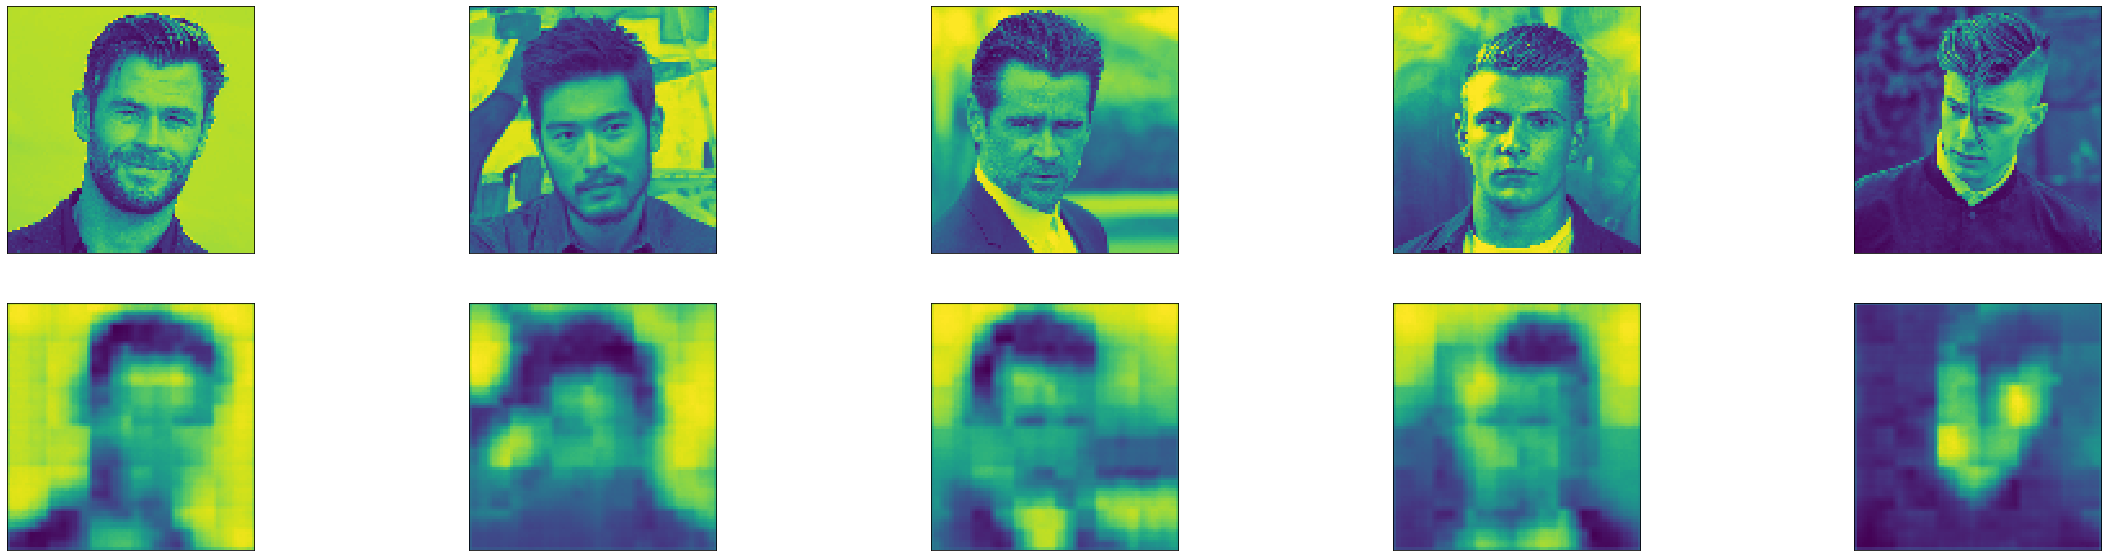

In [17]:

n = 5# how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_imgs[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

###Pre-processing new data set

In [18]:
tn_path = "/content/drive/My Drive/downloads/test_normal.jpg"      #a normal image same as the first image in test_data
tnois_path = "/content/drive/My Drive/downloads/test_noise.jpg"    #a little bit of noise added using paint
tbb_path = "/content/drive/My Drive/downloads/test_bald_beard.jpg" #a bald image with a beard
tbn_path = "/content/drive/My Drive/downloads/test_bald.jpg"       #a bald image with no beard

n1 = (tn_path)
n2 = (tnois_path)
n3 = (tbb_path)
n4 = (tbn_path)

all_new = []

all_new.append(n1)
all_new.append(n2)
all_new.append(n3)
all_new.append(n4)

all_new
    


['/content/drive/My Drive/downloads/test_normal.jpg',
 '/content/drive/My Drive/downloads/test_noise.jpg',
 '/content/drive/My Drive/downloads/test_bald_beard.jpg',
 '/content/drive/My Drive/downloads/test_bald.jpg']

In [19]:
#import data in (96,96,1) grey scale image
new_data = []

#New data
for img in all_new:
    img = cv2.imread(str(img),0)
    img = cv2.resize(img, (96,96))   
    img = img.astype(np.float32)/255.
    img = np.expand_dims(img,-1)
    new_data.append(img)

new_data = np.array(new_data)
print(new_data.shape)

(4, 96, 96, 1)


### Dispaly of new testing data set

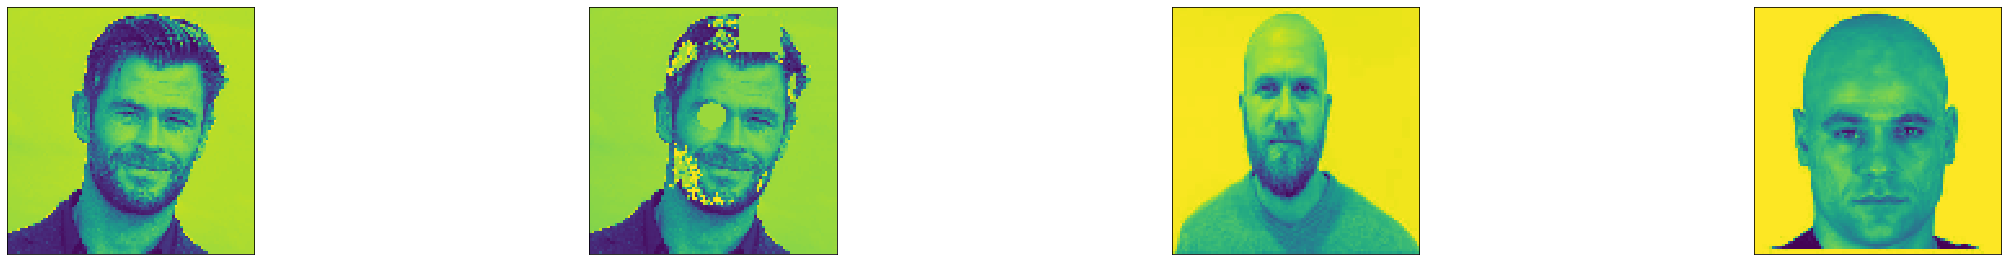

In [20]:
n = 4# how many digits we will display
plt.figure(figsize=(40,10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(new_data[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

###Autoencoder model prediction with new data set

In [0]:
new_input = autoencoder.predict(new_data, batch_size=1)



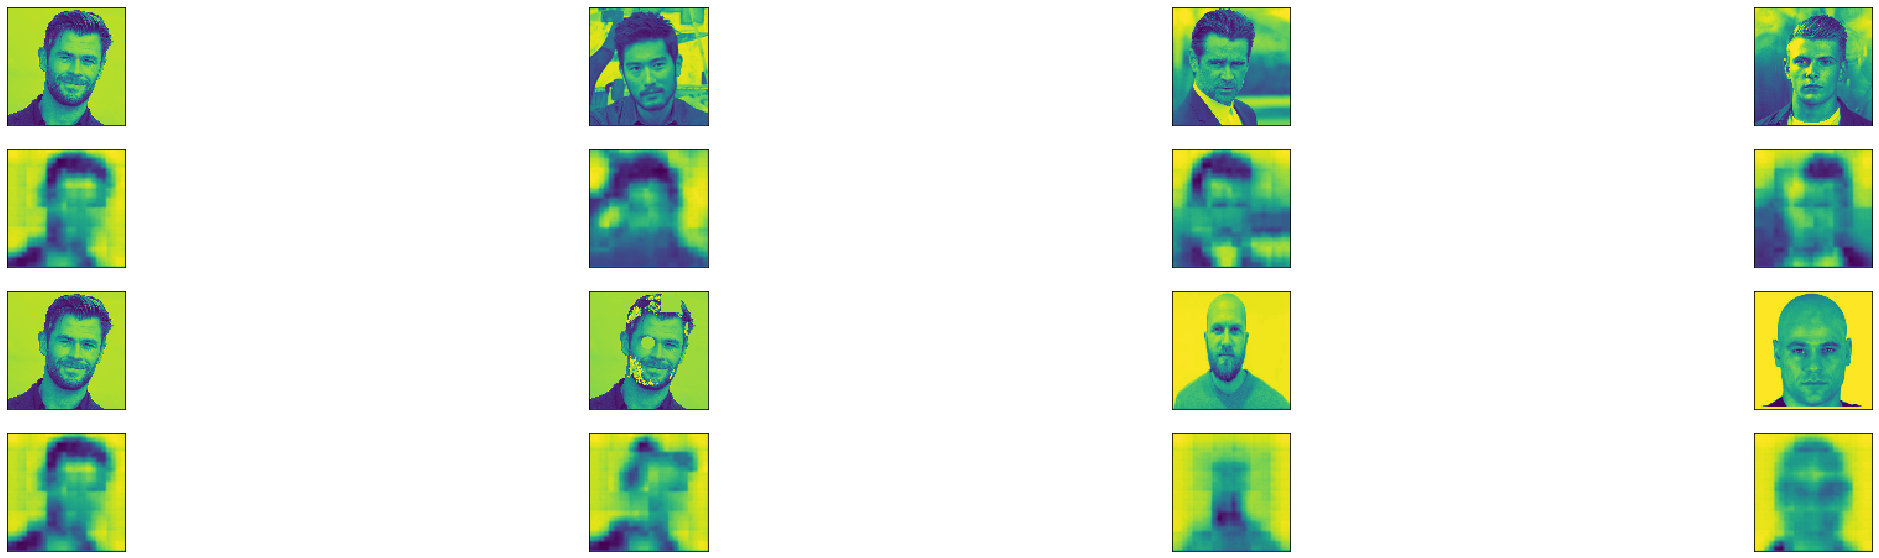

In [22]:
#Display

n = 4# how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(test_data[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # dispay reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(recon_imgs[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # new input
    ax = plt.subplot(4, n, i + 1 + n + n)
    plt.imshow(new_data[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # new input prediction
    ax = plt.subplot(4, n, i + 1 + n + n + n)
    plt.imshow(new_input[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

###Building Variational Autoencoder

In [23]:
#Encoding  - mapping image inputs to latent distribution parameters
latent_dim = 2



input_img = Input(shape=(96,96,1))  # adapt this if using `channels_first` image data format


x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.20)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.20)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

shape_before_flattening = K.int_shape(encoded)

x = Flatten()(encoded)
encoded_to_z = Dense(32, activation='relu')(x)


#Tow outputs, latent mean and (log) variance
z_mean = Dense(latent_dim)(encoded_to_z)
z_log_var = Dense(latent_dim)(encoded_to_z)

print(z_mean)
print(z_log_var)

Tensor("dense_2/BiasAdd:0", shape=(?, 2), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(?, 2), dtype=float32)


In [24]:
# Using previous parameters to sample new similar points from the latent space

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(1,2), mean=0., stddev = 1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

print(z)
print(shape_before_flattening[1:])

Tensor("lambda_1/add:0", shape=(?, 2), dtype=float32)
(6, 6, 32)


In [0]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

#Decoding part - mapping sampled latent points back to reconstructed inputs
#Expand to 1152 total pixels
x = Dense(1152, activation='relu')(decoder_input)

#Reshape (6,6,32)
x = Reshape(shape_before_flattening[1:])(x)


#Decoder
x = Conv2DTranspose(256, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(64, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(64, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(32, (2,2),padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(1,(3,3), activation='sigmoid', padding='same')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)


In [0]:
#a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1. - z_log_var, axis=1)
    
    return recon + kl


###Variational Autoencoder model

In [27]:
vae = Model(input_img, z_decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 96, 96, 128)  1280        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 48, 48, 128)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 48, 48, 64)   73792       max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [28]:
vae.fit(train_data, train_data,
        shuffle=False,
        epochs=300,
        steps_per_epoch= int(len(train_data)/64),
        validation_steps= int(len(test_data)/64),
        validation_data=(test_data,test_data),verbose=1)

Train on 455 samples, validate on 86 samples
Epoch 1/300
7/7 [==============================] - 9s 1s/step - loss: 66.5240 - val_loss: 66.4269
Epoch 2/300
7/7 [==============================] - 6s 841ms/step - loss: 66.4268 - val_loss: 66.2620
Epoch 3/300
7/7 [==============================] - 6s 842ms/step - loss: 66.2879 - val_loss: 66.4533
Epoch 4/300
7/7 [==============================] - 6s 840ms/step - loss: 66.1592 - val_loss: 65.8675
Epoch 5/300
7/7 [==============================] - 6s 840ms/step - loss: 65.9490 - val_loss: 65.7419
Epoch 6/300
7/7 [==============================] - 6s 838ms/step - loss: 65.9230 - val_loss: 65.6922
Epoch 7/300
7/7 [==============================] - 6s 839ms/step - loss: 65.7916 - val_loss: 65.6592
Epoch 8/300
7/7 [==============================] - 6s 840ms/step - loss: 65.6516 - val_loss: 65.7420
Epoch 9/300
7/7 [==============================] - 6s 845ms/step - loss: 65.6899 - val_loss: 65.6955
Epoch 10/300
7/7 [==============================]

In [29]:
#VAE performance
train_eva = vae.evaluate(train_data, train_data,steps=int(len(train_data)/32), verbose=0)
print("Train loss = %f" % (train_eva))
test_eva = vae.evaluate(test_data, test_data,steps=int(len(test_data)/32),verbose=0)
print("Test loss = %f" % (test_eva))

Train loss = 61.109152
Test loss = 62.159470


In [0]:
vae.save('vae_h1')

###VAE prediction from test data

In [0]:
result_imgs1 = vae.predict(test_data, batch_size = int(len(test_data)/64), verbose=0)


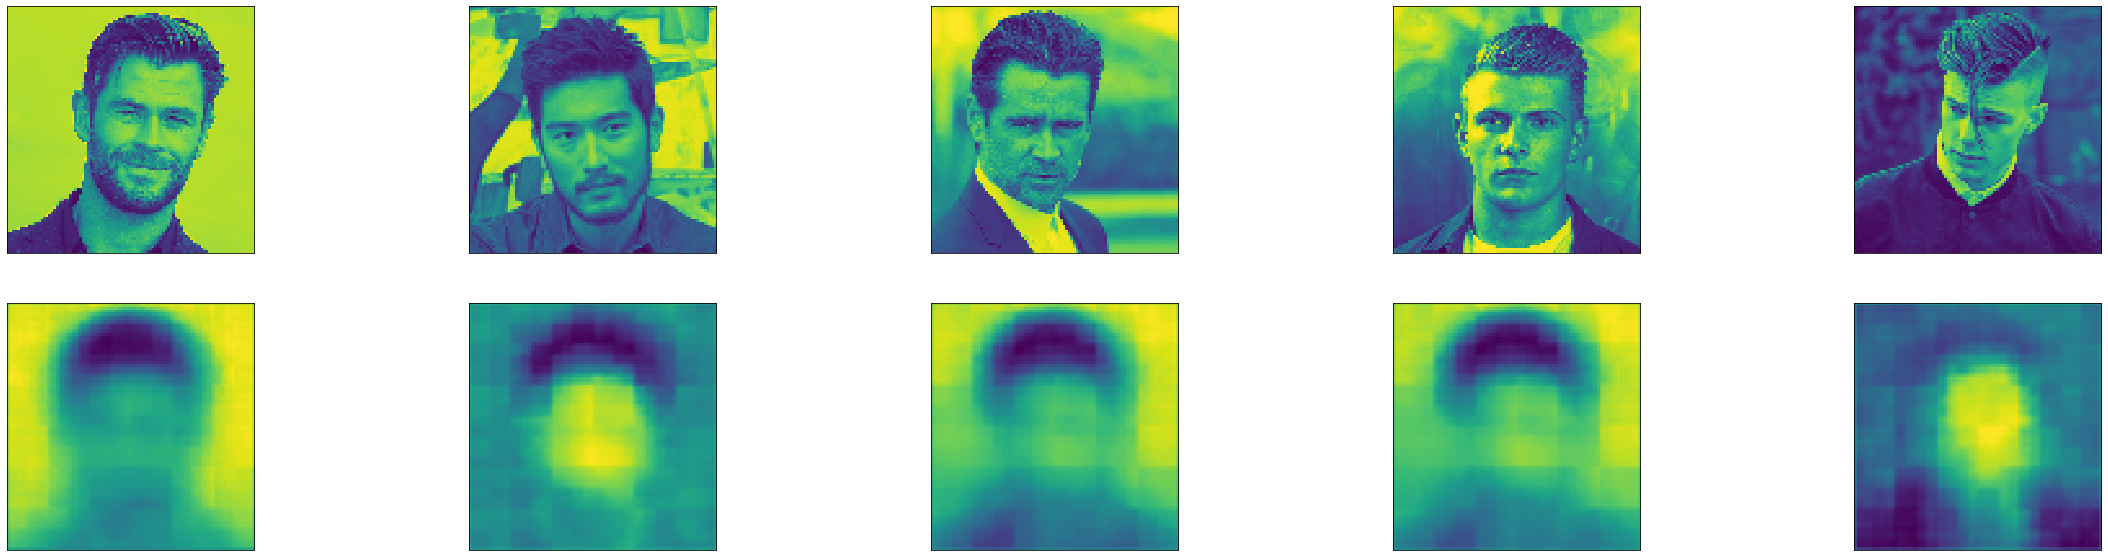

In [32]:


n = 5# how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(result_imgs1[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### VAE prediction from new test data

In [0]:
new_input1 = vae.predict(new_data, batch_size=1)


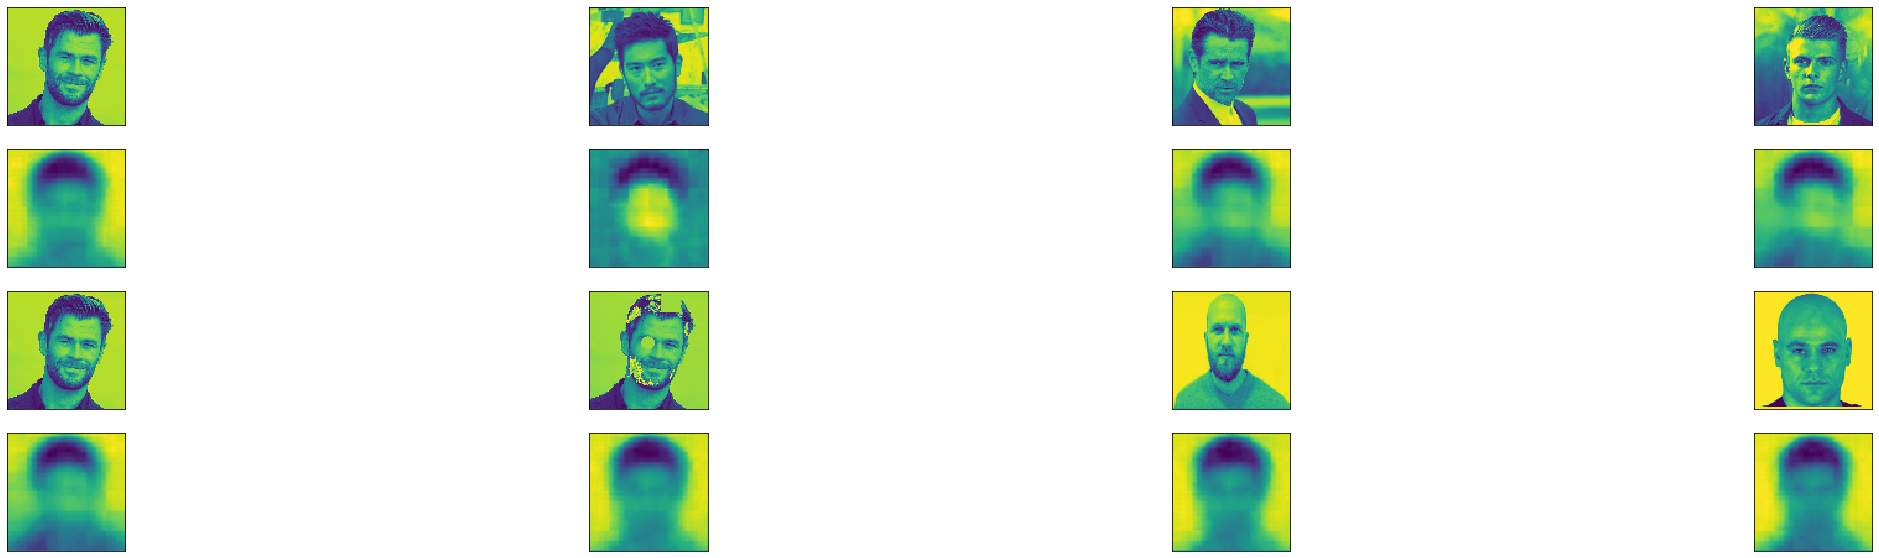

In [34]:
n = 4# how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(test_data[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # dispay reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(result_imgs1[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # new input
    ax = plt.subplot(4, n, i + 1 + n + n)
    plt.imshow(new_data[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
     # new input prediction
    ax = plt.subplot(4, n, i + 1 + n + n + n)
    plt.imshow(new_input1[i].reshape(96,96))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

###Loss plots

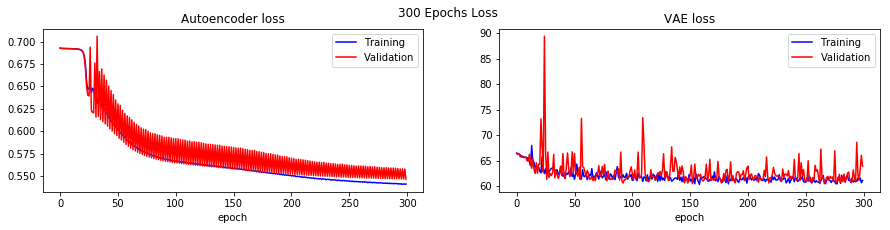

In [35]:
loss = [autoencoder.history.history['loss'],autoencoder.history.history['val_loss']]
loss1 = [vae.history.history['loss'],vae.history.history['val_loss']]
    
fig, axes = plt.subplots(1,2,figsize = (15,3))
fig.suptitle('300 Epochs Loss' )
for ax,val,name in zip(axes,(loss,loss1),['Autoencoder loss','VAE loss']):
        ax.plot(val[0], color='b', label="Training")
        ax.plot(val[1], color='r', label="Validation")
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

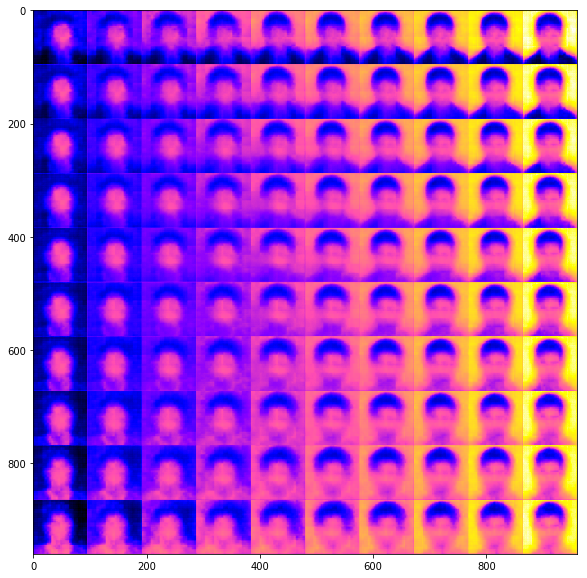

In [36]:
# use the decoder network to take a peak at what samples from the latent space look like as we change the latent variables.
# Display a 2D manifold of the hairstyle

n = 10  # figure with 10x10 images
digit_size = 96
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, 64).reshape(64, 2)
        x_decoded = decoder.predict(z_sample, batch_size=64)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  